In [2]:
from pathlib import Path

import numpy as np
from tqdm import tqdm

import idmlaser.kmcurve as kmcurve
import idmlaser.pyramid as pyramid
from idmlaser.models.numpynumba import STATE_ACTIVE
from idmlaser.models.numpynumba import NumbaSpatialSEIR
from idmlaser.numpynumba import DemographicsByYear
from idmlaser.utils import PriorityQueueNB
from idmlaser.utils import PropertySet

SCRIPT_PATH = Path.cwd().absolute()

meta_params = PropertySet(
    {
        "ticks": 365,
        "nodes": 1,
        "seed": 20240702,
        "output": Path.cwd() / "outputs",
    }
)

model_params = PropertySet(
    {
        "exp_mean": np.float32(7.0),
        "exp_std": np.float32(1.0),
        "inf_mean": np.float32(7.0),
        "inf_std": np.float32(1.0),
        "r_naught": np.float32(14.0),
        "seasonality_factor": np.float32(0.125),
        "seasonality_offset": np.float32(182),
    }
)

params = PropertySet(meta_params, model_params)

model = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=1, nnodes=1)
CAPACITY = 1_000_000
demographics.initialize(initial_population=CAPACITY)

max_capacity = CAPACITY
INFECTIONS = 10
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0, :] = [CAPACITY - INFECTIONS, 0, INFECTIONS, 0]  # S, E, I, R
network = np.zeros((1, 1), dtype=np.float32)  # 1x1 network
model.initialize(max_capacity, demographics, initial, network)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mType of variable '$24compare_op.6' cannot be determined, operation: unknown operation, location: unknown location (0:0)
[1m
File "unknown location", line 0:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [ ]:
def init_dobs_dods(filename, dobs, dods, seed=20240703):
    popdata = pyramid.load_pyramid_csv(filename)
    prng = np.random.default_rng(seed)
    agedist = pyramid.AliasedDistribution(popdata[:, 4], prng=prng)  # ignore sex for now
    indices = agedist.sample(dobs.shape[0])
    minage = popdata[:, 0] * 365  # closed interval (include this value)
    limage = (popdata[:, 1] + 1) * 365  # open interval (do not include this value)
    print("Converting age-bin indices to dates of birth...")
    for i in tqdm(range(len(popdata))):
        mask = indices == i
        dobs[mask] = prng.integers(low=minage[i], high=limage[i], size=mask.sum())
    print("Converting dates of birth to dates of death...")
    for i in tqdm(range(len(dobs))):
        dods[i] = kmcurve.predicted_day_of_death(dobs[i])
    dods -= dobs.astype(dods.dtype)  # renormalize to be relative to _now_ (t=0)
    dobs = -dobs  # all _living_ agents have dates of birth before now (t=0)

    return


model.population.add_property("dod", dtype=np.int32)
init_dobs_dods(
    SCRIPT_PATH / "USA-pyramid-2023.csv", model.population.dob, model.population.dod, seed=params.seed
)  # 2023 is the most recent year of data

print(f"Pushing {model.population.dod.shape[0]} agents onto the priority queue...")
pq = PriorityQueueNB(model.population.dod.shape[0], model.population.dod)
for i in tqdm(range(model.population.dod.shape[0])):
    pq.push(i)

# temp
# print(f"Popping {model.population.dod.shape[0]} agents off the priority queue...")
# for _ in tqdm(range(model.population.dod.shape[0])):
#     pq.pop()

model.queues = [pq]



Reading data from '/Users/christopherlorton/projects/laser/tests/USA-pyramid-2023.csv' ...
Converting age-bin indices to dates of birth...


100%|██████████| 21/21 [00:00<00:00, 727.40it/s]


Converting dates of birth to dates of death...


100%|██████████| 1000000/1000000 [00:06<00:00, 164840.75it/s]


Pushing 1000000 agents onto the priority queue...


100%|██████████| 1000000/1000000 [00:01<00:00, 957133.61it/s]


In [ ]:
# HACK, HACK, HACK

def non_disease_deaths(model, tick) -> None:
    states = model.population.states
    pq = model.queues[0]  # only one node, right now
    while (pq.size > 0) and (i := pq.peekv() == tick):
        pq.pop()
        states[i] = 0  # dead
    return


model._phases.insert(0, non_disease_deaths)

# KCAH, KCAH, KCAH


In [ ]:
model.run(params.ticks)

# model.report : ticks x channels x nodes
print(model.report.shape)
print(model.report[30:50, :, 0])



100%|██████████| 365/365 [00:01<00:00, 208.58it/s]

elapsed time: 0:00:01.751406
(366, 4, 1)
[[878041 103072  16160   2727]
 [841906 133388  21065   3641]
 [797067 170482  27589   4862]
 [740929 216134  36474   6463]
 [672340 271139  47879   8642]
 [590519 335007  63046  11428]
 [496888 406029  82073  15010]
 [394461 479656 106221  19662]
 [290509 546529 137278  25684]
 [192579 598492 175047  33882]
 [111083 623143 221081  44693]
 [ 52223 613405 275609  58763]
 [ 18355 566319 338126  77200]
 [  4088 488206 407089 100617]
 [   360 393294 476085 130261]
 [     0 294244 537791 167965]
 [     0 201293 583695 215012]
 [     0 122803 604799 272398]
 [     0  64770 594027 341203]
 [     0  28628 549876 421496]]


In [ ]:
metrics = np.array(model.metrics)
for c in range(metrics.shape[1]):
    if c == 0:
        continue
    print(f"{model._phases[c-1].__name__:20}: {metrics[:,c].sum():11,} μs")
print("====================================")
print(f"total               : {metrics[:, 1:].sum():,} μs")


non_disease_deaths  :     376,778 μs
vital_dynamics      :       8,216 μs
infection_update    :      72,417 μs
incubation_update   :      73,487 μs
transmission_update :     513,596 μs
report_update       :     693,749 μs
total               : 1,738,243 μs


In [ ]:
print("Goodbye [cruel], world!")


Goodbye [cruel], world!


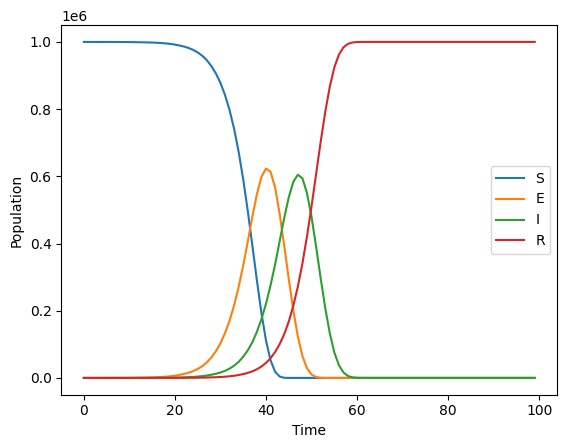

In [ ]:
import matplotlib.pyplot as plt

# Extract the "S", "E", "I", and "R" channels from model.report
s_channel = model.report[0:100, 0, 0]
e_channel = model.report[0:100, 1, 0]
i_channel = model.report[0:100, 2, 0]
r_channel = model.report[0:100, 3, 0]

# Plot the channels
plt.plot(s_channel, label="S")
plt.plot(e_channel, label="E")
plt.plot(i_channel, label="I")
plt.plot(r_channel, label="R")

# Add labels and legend
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()

# Show the plot
plt.show()